<a href="https://colab.research.google.com/github/Grinnday/FitSNAP/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


# Step 0: Inport dataset, libraries

In [3]:
import sys
from google.colab import drive
drive.mount('/content/drive')
%cp -r /content/drive/MyDrive/Physics/Fraunhofer/Datasets/TinaSet/distributions /content
%cp -r /content/drive/MyDrive/Physics/Fraunhofer/Datasets/TinaSet/fields /content
sys.path.append('/content/promethAI/src')
import GeneralFunc
import lumerical2python as L2P

Mounted at /content/drive


In [120]:
np.shape(coordinates)

(400, 2, 24)

In [135]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Install LAMMPS and FitSNAP

If you are running locally and have already installed LAMMPS and FitSNAP, skip this step.

In [9]:
# Install LAMMPS with Python interface.

!apt-get update
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.10-venv
!pip install --upgrade pip
!pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
!pip install ase
!pip install fitsnap3
%cd /content
!rm -rf lammps
!git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
!rm -rf build
!mkdir build
%cd build
!cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_ML-SNAP=yes \
               -DPKG_ML-IAP=yes \
               -DPKG_ML-PACE=yes \
               -DPKG_SPIN=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`
!make -j 2
!make install-python

# Install FitSNAP.

%cd /content
!rm -rf FitSNAP
!git clone https://github.com/FitSNAP/FitSNAP
#!git clone -b collected-changes https://github.com/rohskopf/FitSNAP

# Set environment variables.

!$PYTHONPATH
%env PYTHONPATH=/env/python:/bin/bash:
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build

# Move into FitSNAP directory
%cd FitSNAP

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,998 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:13 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy/main amd64 Packages [4

# Check if Python LAMMPS is working and opening example data

In [11]:
import lammps
lmp = lammps.lammps()
print(lmp)

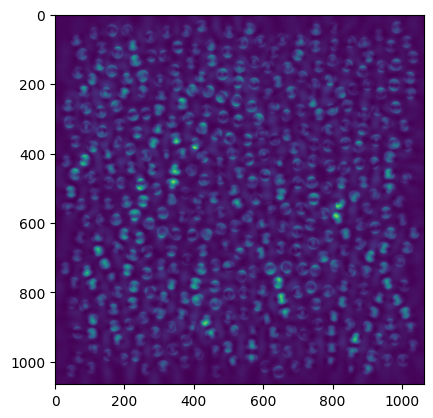

In [206]:
file_ = '/content/fields/box_d20_M24_NN0_s0.8_m3.mat'
B = L2P.load_lumerical_mat(file_,load_item = 'E', silent=2)
B = B['T'].E
B = B[:,:,0,0,:]
s = np.shape(B)
plt.imshow(np.sum(abs(B)**2, axis = 2))
plt.show()
coo = coordinates/int(20)*(s[0]-64)+32
B_ = np.array([B[int(i[0])-30:int(i[0])+30, int(i[1])-30:int(i[1])+30].mean(axis=(0,1)) for i in coo])
#B_ = np.sum(abs(B_)**2, axis = -1)

In [208]:
dir = '/content/distributions/box_d20_M24_NN0.mat'
image = scipy.io.loadmat(dir)['points'].squeeze()
coordinates = image[:,:,2]

# Write data to the XYZ file
#!mkdir /content/sample_data/XYZ
with open("/content/sample_data/XYZ/box_d20_M24_NN0.xyz", "w") as xyz_file:
    xyz_file.write(str(len(coordinates))+'\n')
    xyz_file.write('Lattice = "20.0 0.0 0.0 0.0 20.0 0.0 0.0 0.0 20.0" Properties=species:S:1:pos:R:3:forces:R:3 energy=1 stress="0 0 0 0 0 0 0 0 0\n')
    for i in range(len(coordinates)):
        line = coordinates[i]
        x, y = line   # adding the coordinates x, y, z=0
        e1,e2,e3 = abs(B_[i])   # adding here the target electric field, but not sure thats the way to go
        xyz_file.write(f"{'H'}\t{x}\t{y}\t{0}\t{e1}\t{e2}\t{e3}\n")

# Basic use: define paramters and create instance of fitSNAP

Necessary imports:

In [10]:
from mpi4py import MPI
import numpy as np
from fitsnap3lib.fitsnap import FitSnap

Generating your first pickled library of CG coefficients. This will take a few moments...
Generating your first pickled library of Wigner 3j coefficients. This will take a few moments...


Then set up a communicator. In this simple example we will use the world communicator, which will actually get chosen by default if you optionally choose to not specify a communicator. Important points on parallelism:

- To take advantage of MPI processes, you must put these lines in a script and run like `mpirun -np P script.py`.
- Examples of this are shown in the `examples/library` directory.

In [13]:
# Set up your communicator.
comm = MPI.COMM_WORLD

The first mandatory step is to create input containing desired settings. These settings include everything from which descriptors to calculate, descriptor settings, which solver to use in performing a fit, how to separate the data into groups, and other options.

Import points on input settings:
- `settings` can be a dictionary defined like below, or a path to a traditional FitSNAP input script like `/path/to/Ta-example.in`.
- Some sections are not required. E.g.
    - `SCRAPER` is only required if you want to use native file scrapers.
    - `SOLVER` is only required if you want to use native model solvers and error analysis.
    - `GROUPS` is only required if you want to define groups of configurations with names and loss function weights.

In [209]:
# Create an input dictionary containing settings.

settings = \
{
"BISPECTRUM":
    {
    "numTypes": 1,
    "twojmax": 6,
    "rcutfac": 4.67637,
    "rfac0": 0.99363,
    "rmin0": 0.0,
    "wj": 1.0,
    "radelem": 0.5,
    "type": "H",
    "wselfallflag": 0,
    "chemflag": 0,
    "bzeroflag": 0,
    "quadraticflag": 0,
    },
"CALCULATOR":
    {
    "calculator": "LAMMPSSNAP",
    "energy": 1,
    "force": 0,
    "stress": 0
    },
"ESHIFT":
    {
    "H": 0.0
    },
"SOLVER":
    {
    "solver": "SVD",
    "compute_testerrs": 1,
    "detailed_errors": 1
    },
"SCRAPER":
    {
    "scraper": "XYZ"
    },
"PATH":
    {
    "dataPath": "/content/sample_data/XYZ"
    },
"OUTFILE":
    {
    "metrics": "box_metrics.md",
    "potential": "box_pot"
    },
"REFERENCE":
    {
    "units": "metal",
    "atom_style": "atomic",
    "pair_style": "hybrid/overlay zero 10.0 zbl 4.0 4.8",
    "pair_coeff1": "* * zero",
    "pair_coeff2": "* * zbl 73 73"
    },
"EXTRAS":
    {
    "dump_dataframe": 1
    },
"GROUPS":
    {
    "group_sections": "name training_size testing_size eweight fweight vweight",
    "group_types": "str float float float float float",
    "smartweights": 0,
    "random_sampling": 0,
    "box_d20_M24_NN0" :  "1.0    0.0       100             1               1.00E-08"    }
}

Create an instance of `fitsnap` by feeding this input dictionary, along with the optional communicator, into the `FitSnap` class.

In [210]:
fs = FitSnap(settings, comm=comm, arglist=["--overwrite"])

This creates a `fitsnap` instance which contains its own data, such as shared and distributed memory arrays in `fitsnap.pt`, and input settings in `fitsnap.config`. The shared and distributed memory arrays are associated with all processes in the supplied communicator `comm`.

Now we can use high-level library functions to perform a fit, with the following steps:
1. Scrape data to fit to. This is parallelized over all processes in `comm` with data stored in the `fitsnap.data` dictionary. Each MPI process has a different list of `data` dictionaries.
2. Calculate descriptors. This is parallelized over all processes in `comm` by operating on each configuration in `fitsnap.data`.
3. Fit potential. This is not parallelized over processes in most basic examples, e.g. the SVD solver will use all the data in a shared array on rank 0, and perform a simple least squares fit.

### 1. Scrape data

This step collects data (configurations of atoms) and injects it into a list of `FitSnap` data dictionaries. Users are
free to do this manually using their own formats. We will explore this option later in the tutorial. Here we provide a native
high-level function `scrape_functions()` for this purpose. As an instance owned function, `scrape_configs()` will scrape
according to the previously input `settings`. Most high-level functions in `FitSnap` act the same way; the `settings`
determine the state of a `FitSnap` instance which then determines the behavior of the high-level functions.

In [211]:
fs.scrape_configs()

box_d20_M24_NN0 : Detected  1  fitting on  1  testing on  0
'scrape_configs' took 6.20 ms on rank 0


This generates a list of `FitSnap` data dictionaries:

In [124]:
print(len(fs.data))

1


Each dictionary is formated like:

In [125]:
print(fs.data[0])

{'pbc': [True, True, True], 'AtomTypes': ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'

This is the format used by `FitSnap` to feed data into LAMMPS for descriptor calculations in the next step.

### 2. Calculate descriptors

Here we use the native high-level `process_configs()` function, which does the following:
- Allocates shared memory arrays (if using MPI) to store descriptor and fitting information.
- Loop through all the configurations in the `fitsnap.data` list of dictionaries containing configuration info.
- Calculate descriptors for these configurations and store the information in the shared arrays `fitsnap.pt.shared_arrays`.

In [212]:
fs.process_configs()

'process_configs' took 284.46 ms on rank 0


In [213]:
fs.pt.shared_arrays.values()

dict_values([<fitsnap3lib.parallel_tools.SharedArray object at 0x7ee742968a00>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee74297e860>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee73f9df070>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee74296a890>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee742969f30>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee74296a950>, <fitsnap3lib.parallel_tools.SharedArray object at 0x7ee74296bf10>])

### 3. Perform fit

Fit a model with the native high-level `perform_fit()` function, which does the following:

- Solves the ML problem to get model coefficients, such as with linear regression or NNs, depending on the choice of
  solver in the `settings` dictionary.
- Analyze errors associated with the fits, which are stored in the `fitsnap.solver.errors` dataframe.

In [215]:
fs.perform_fit()#a, B_, None,  a[:30]

'fit' took 0.30 ms on rank 0
'error_analysis' took 23.49 ms on rank 0


/content/FitSNAP/fitsnap3lib/solvers/solver.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  rsq = 1 - ssr / np.sum(np.square(g['truths'] - (g['truths'] / nconfig).sum()))
/content/FitSNAP/fitsnap3lib/solvers/solver.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  w_rsq = 1 - w_ssr / np.sum(np.square((g['weights'] * g['truths']) - (g['weights'] * g['truths'] / w_nconfig).sum()))
/content/FitSNAP/fitsnap3lib/solvers/solver.py:126: RuntimeWarning: divide by zero encountered in scalar divide
  rsq = 1 - ssr / np.sum(np.square(g['truths'] - (g['truths'] / nconfig).sum()))
/content/FitSNAP/fitsnap3lib/solvers/solver.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  w_rsq = 1 - w_ssr / np.sum(np.square((g['weights'] * g['truths']) - (g['weights'] * g['truths'] / w_nconfig).sum()))


Useful objects generated by this fit:

In [218]:
# Dataframe of detailed errors per group.
print(fs.solver.errors)

                                               ncount           mae  \
Group           Weighting  Testing  Subsystem                         
*ALL            Unweighted Training Energy          1  2.273737e-13   
                weighted   Training Energy          1  2.273737e-11   
box_d20_M24_NN0 Unweighted Training Energy          1  2.273737e-13   
                weighted   Training Energy          1  2.273737e-11   

                                                       rmse  rsq  
Group           Weighting  Testing  Subsystem                     
*ALL            Unweighted Training Energy     2.273737e-13 -inf  
                weighted   Training Energy     2.273737e-11 -inf  
box_d20_M24_NN0 Unweighted Training Energy     2.273737e-13 -inf  
                weighted   Training Energy     2.273737e-11 -inf  


In [217]:
# List of fitting coefficients (for linear models).
print(fs.solver.fit)

[-1.38759801e-05 -1.18359909e-01 -6.58584705e-03 -7.88707768e-04
 -3.98537144e-02 -1.39321476e-03  1.29602169e-02 -1.32956150e-02
 -2.72892976e-03 -5.69409566e-04  6.92157096e-04 -7.69567418e-04
 -1.66046287e-04 -3.52123185e-04 -2.43019205e-02 -8.37083880e-04
  7.74587670e-03 -8.02699721e-03  2.78980129e-04 -4.78852801e-03
  4.63536656e-03 -3.31927377e-03 -6.12390048e-04  1.82762113e-04
 -9.97978882e-05 -3.52299232e-04  3.28945298e-05 -2.02068832e-02
  4.90020513e-03 -3.62960681e-03  2.20564248e-03]


In [ ]:
# Dataframe containing all fitting info and metrics.
print(fs.solver.df)

### 4. Writing output files

In [ ]:
# Write LAMMPS potential files.
fs.output.write_lammps(fs.solver.fit)
# Write error analysis.
fs.output.write_errors(fs.solver.errors)
# Look at files:
!ls

# Perform fits on multiple instances with different settings

Let's say we want to perform multiple fits with different settings, like different `twojmax` values.

In [ ]:
# Make list of twojmax values to scan:
twojmax_list = [2,4,6,8,10]
# Make list of settings for each twojmax:
from copy import deepcopy
settings_list = [deepcopy(settings) for i in twojmax_list]
for i, twojmax in enumerate(twojmax_list):
    settings_list[i]["BISPECTRUM"]["twojmax"] = twojmax

print(len(settings_list))

Make a list of `FitSnap` instances, each with different settings:

In [ ]:
instances = [FitSnap(setting, comm=comm, arglist=["--overwrite"]) for setting in settings_list]
print(instances)

Loop over all instances and fit:

In [ ]:
for i, instance in enumerate(instances):
    print(f"--- Instance {i} with twojmax = {instance.config.sections['BISPECTRUM'].twojmax}")
    # No need to scrape configurations again, just use the previously scraped configs by injecting
    # the previous instance data into this instance data.
    instance.process_configs(data=fs.data)
    # Perform fit using the internal fitting data of this instance.
    instance.perform_fit()
    # Grab errors.
    f_mae = instance.solver.errors['mae'][('*ALL', 'Unweighted', 'Training', 'Force')]
    e_mae = instance.solver.errors['mae'][('*ALL', 'Unweighted', 'Training', 'Energy')]

Look at the errors:

In [ ]:
# Now each instance contains fitting information (configurations and their descriptors) and errors.
for instance in instances:
    # Extract specific errors from the errors dataframe.
    # NOTE: No `Testing` key will exist if no testing groups were defined in `settings`.
    ftest_mae = instance.solver.errors['mae'][('*ALL', 'Unweighted', 'Training', 'Force')]
    etest_mae = instance.solver.errors['mae'][('*ALL', 'Unweighted', 'Training', 'Energy')]
    print(f"{instance.config.sections['BISPECTRUM'].twojmax[0]} \
          {ftest_mae:0.5f}     {etest_mae:0.5f}")

#### Note on shared memory (if using MPI).
If using MPI, each instance allocates shared memory for storing the parallel arrays. Users must therefore take care to not allocate too many `FitSnap` instances, and to properly free memory associated with unused instances. We free shared array memory by overriding the `del` statement in `FitSnap`:

In [ ]:
# Free shared memory of all instances (only necessary if using MPI):
for instance in instances:
    del instance

This example looped over fits sequentially, where each fit shared the same communicator. One could however use split communicators to achieve fits in parallel.

# How to just get the descriptors for a data set?

### Extracting SNAP descriptors.

Sometimes we want to simply extract descriptors for data analysis without going through the pain of
performing a fit.

TODO: Show example of extracting descriptors from configs then doing data analysis (t-SNE)

Loop over configurations and calculate descriptors for each separately.

Use our ASE scraper to inject a list of `Atoms` objects into a particular instance:

If we're only calculating descriptors, we just need a simple `settings` dictionary.

In [147]:
settings = \
{
"BISPECTRUM":
    {
    "numTypes": 1,
    "twojmax": 6,
    "rcutfac": 5.0,
    "rfac0": 0.99363,
    "rmin0": 0.0,
    "wj": 1.0,
    "radelem": 0.5,
    "type": "H",
    "wselfallflag": 0,
    "bzeroflag": 1,
    "bikflag": 1
    },
"CALCULATOR":
    {
    "calculator": "LAMMPSSNAP",
    "energy": 1,
    "force": 0,
    "stress": 0,
    "per_atom_energy": 1
    },
"REFERENCE":
    {
    "units": "micro",
    "atom_style": "atomic",
    "pair_style": "zero 6.0",
    "pair_coeff": "* *"
    }
}

Get data from ASE `Atoms` objects:

In [148]:
fs = FitSnap(settings, arglist=["--overwrite"])

### Extracting ACE descriptors.

Make an instance like usual:

In [51]:
!pip install ase
from ase.io import read

<class 'list'>


In [150]:
from fitsnap3lib.scrapers.ase_funcs import ase_scraper
data = ase_scraper(frames)

In [149]:
frames = read("/content/sample_data/XYZ/box_d20_M24_NN0.xyz", ":")
print(type(frames))

<class 'list'>


In [152]:
for i, configuration in enumerate(data):
    print(i)
    a,b,w = fs.calculator.process_single(configuration)
    print(np.shape(a))

0
(400, 30)


### WARNING: ACE descriptors are not supported in colab yet.

Declare settings dictionary:

In [ ]:
settings = \
{
"ACE":
    {
    "numTypes": 1,
    "ranks": "1 2 3",
    "lmax":  "1 2 2",
    "nmax": "22 2 2",
    "nmaxbase": 22,
    "rcutfac": 4.604694451,
    "lambda": 3.5,
    "type": "Ta",
    "lmin": 0,
    "bzeroflag": 1,
    "bikflag": 1,
    "RPI_heuristic": "root_SO3_span"
    },
"CALCULATOR":
    {
    "calculator": "LAMMPSPACE",
    "energy": 1,
    "force": 0,
    "stress": 0,
    "per_atom_energy": 1
    },
"REFERENCE":
    {
    "units": "metal",
    "atom_style": "atomic",
    "pair_style": "zero 6.0",
    "pair_coeff": "* *"
    }
}

Make `FitSnap` instance:

In [ ]:
fs = FitSnap(settings, arglist=["--overwrite"])

Get configurations from somewhere (e.g. ASE):

In [ ]:
from ase.io import read
from fitsnap3lib.scrapers.ase_funcs import ase_scraper
frames = read("examples/Ta_XYZ/XYZ/Displaced_FCC.xyz", ":")
data = ase_scraper(frames)

Now this `FitSnap` instance has a list of dictionaries containing structural info:

In [ ]:
print(len(data))

Loop over these configurations and calculate ACE descriptors:

In [ ]:
for i, configuration in enumerate(data):
    print(i)
    a,b,w = fs.calculator.process_single(configuration)
    print(np.shape(a))

# How to process configs once then do multiple fits?

This is useful if doing many fits with the same calculator (descriptor) settings but different solver settings. We can do this by:

1. Using one `FitSnap` instance to process configs and store data in its shared arrays.
2. Using this data as input to the solver functions of another instance.

First let's make an instance for calculating descriptors.


In [ ]:
settings = \
{
"BISPECTRUM":
    {
    "numTypes": 1,
    "twojmax": 6,
    "rcutfac": 4.67637,
    "rfac0": 0.99363,
    "rmin0": 0.0,
    "wj": 1.0,
    "radelem": 0.5,
    "type": "Ta",
    "wselfallflag": 0,
    "chemflag": 0,
    "bzeroflag": 1,
    "bikflag": 1,
    "dgradflag": 1
    },
"CALCULATOR":
    {
    "calculator": "LAMMPSSNAP",
    "energy": 1,
    "force": 1,
    "per_atom_energy": 1,
    "nonlinear": 1
    },
"PYTORCH":
    {
    "layer_sizes": "num_desc 64 64 1",
    "learning_rate": 1e-4,
    "num_epochs": 10,
    "batch_size": 4, # 363 configs in entire set
    "save_state_output": "Ta_Pytorch.pt"
    },
"SOLVER":
    {
    "solver": "PYTORCH"
    },
"SCRAPER":
    {
    "scraper": "JSON"
    },
"PATH":
    {
    "dataPath": "examples/Ta_Linear_JCP2014/JSON"
    },
"REFERENCE":
    {
    "units": "metal",
    "atom_style": "atomic",
    "pair_style": "hybrid/overlay zero 6.0 zbl 4.0 4.8",
    "pair_coeff1": "* * zero",
    "pair_coeff2": "* * zbl 73 73"
    },
"GROUPS":
    {
    "group_sections": "name training_size testing_size eweight fweight",
    "group_types": "str float float float float",
    "smartweights": 0,
    "random_sampling": 0,
    "Displaced_A15" :  "0.7 0.3 1e-2 1",
    "Displaced_BCC" :  "0.7 0.3 1e-2 1",
    "Displaced_FCC" :  "0.7 0.3 1e-2 1",
    "Elastic_BCC"   :  "0.7 0.3 1e-2 1",
    "Elastic_FCC"   :  "0.7 0.3 1e-2 1",
    "GSF_110"       :  "0.7 0.3 1e-2 1",
    "GSF_112"       :  "0.7 0.3 1e-2 1",
    "Liquid"        :  "0.7 0.3 1e-2 1",
    "Surface"       :  "0.7 0.3 1e-2 1",
    "Volume_A15"    :  "0.7 0.3 1e-2 1",
    "Volume_BCC"    :  "0.7 0.3 1e-2 1",
    "Volume_FCC"    :  "0.7 0.3 1e-2 1"
    }
}

In [ ]:
fs1 = FitSnap(settings, arglist=["--overwrite"])
fs1.scrape_configs()
fs1.process_configs()

Now use the descriptor data from this instance (which is stored in `fs1.pt`), to perform many fits
with other instances possessing different settings.

In [ ]:
# Fit with one learning rate:
settings2 = deepcopy(settings)
settings2["PYTORCH"]["learning_rate"] = 1e-3
fs2 = FitSnap(settings2, arglist=["--overwrite"])
# Fit with the shared array data from instance `fs1`.
fs2.solver.perform_fit(pt=fs1.pt)

In [ ]:
# Fit with a larger learning rate:
settings3 = deepcopy(settings)
settings3["PYTORCH"]["learning_rate"] = 1e-6
fs3 = FitSnap(settings3, arglist=["--overwrite"])
# Fit with the shared array data from instance `fs1`.
fs3.solver.perform_fit(pt=fs1.pt)

Get errors of the two instances.

In [ ]:
# For NNs, `solver.errors` is currently a tuple of dictionaries.
# Errors for larger learning rate:
fs2.solver.error_analysis()
(mae_f, mae_e, rmse_f, rmse_e, count_train, count_test) = fs2.solver.errors
# Look at force MAE of specific group:
print(mae_f["Displaced_A15"])

In [ ]:
# Errors for smaller learning rate:
fs3.solver.error_analysis()
(mae_f, mae_e, rmse_f, rmse_e, count_train, count_test) = fs3.solver.errors
# Look at force MAE of specific group:
print(mae_f["Displaced_A15"])

# Hiearchical parallelism with custom communicators

These simple examples all used a single world communicator. Our design, however, allows one to create many instances each with a different communicator, to get creative with how fits are done in parallel. For example one could split the communicator among a group of processes, and then perform multiple fits *in parallel*, where each fit is performed in parallel using the processes in its communicator. This is beyond the scope of a iPython notebook since it requires making custom Python scripts with MPI.

# How do the shared arrays work?

Each `FitSnap` instance contains shared arrays inside the `snap.pt.shared_arrays` dictionary. The descriptor array is stored in `snap.pt.shared_arrays['a'].array`. The contents of this array are shared in memory between all processes in the instance communicator `snap.pt._comm` (this is the same communicator we passed when creating the instance). This means that when an element of the shared array is changed on one process in `comm`, it will change the shared array with all other processes in the same communicator. This is important because although each `snap.pt` instance is different for all processes in a communicator, the contents `snap.pt.shared_arrays['a'].array` are shared.